# Bootstrap Aggregating without online sampling
* Not seperating by WSI

In [1]:
import os
import sys
import glob
import random
import pickle
import numpy as np
import pandas as pd
from tqdm import tqdm

import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.utils.data
import torchvision.models as models
from torchvision import datasets, models, transforms
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

from fastai.imports import *
from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *

SEED = 101
np.random.seed(SEED)
from torchvision import datasets, models, transforms

%reload_ext autoreload
%autoreload 2
%matplotlib inline

# Add the src directory for functions
src_dir = os.path.join(os.path.dirname(os.path.dirname(os.getcwd())), 'src')
print(src_dir)
sys.path.append(src_dir)

# import my functions:
from WSI_pytorch_utils import*
from other_functions import*

fast_ai_dir = '/media/rene/Data/fastai/'
sys.path.append(fast_ai_dir)

torch.cuda.set_device(0)
print(torch.cuda.is_available())
print(torch.cuda.current_device())

/media/rene/Data/camelyon/src
True
0


## Make dataset 
* csv with locations pointing to the right images to sample

In [2]:
# # reproduce
# cp -r tiles_224_100t/train/tumor/. tiles_224_100t_all
# cp -r tiles_224_100t/train/normal/. tiles_224_100t_all
# cp -r tiles_224_100t/valid/tumor/. tiles_224_100t_all
# cp -r tiles_224_100t/valid/normal/. tiles_224_100t_all

In [2]:
# get data
data_loc = '/media/rene/Data/camelyon_out/tiles_224_100t_all'
all_imgs = glob.glob(data_loc+'/*')
img_names = [loc.rsplit('/', 1)[-1] for loc in all_imgs]

# load train valid split
ttv_split = np.load('/media/rene/Data/camelyon/other/ttv_split.p')
normal_valid = ttv_split['normal_vaild_idx']
tumor_valid = ttv_split['tumor_vaild_idx']
normal_train = list(range(1, 161))
normal_train = [num for num in normal_train if num not in normal_valid]
tumor_train = list(range(1, 111))
tumor_train = [num for num in tumor_train if num not in tumor_valid]

In [3]:
# get classes corresponding to each file
def get_label(name):
    if name.rsplit('_', 1)[-2][-5:]=='tumor':
        label = 'tumor'
    else: 
        label = 'normal'
    return label

classes = [get_label(name) for name in img_names]

# make csv
labels_df = pd.DataFrame(
    {'file_name': img_names,
     'label': classes
    })

labels_df.to_csv('/media/rene/Data/camelyon_out/tiles_224_100t_all_other/tiles_224_100t_all_labels.csv', index = False)

In [5]:
# get the validation indices from the big list
def is_validation(name, normal_valid, tumor_valid):
    normal_valid = [int(x) for x in normal_valid]
    tumor_valid = [int(x) for x in tumor_valid]
    num = int(name.split('_', 1)[1].split('_', 1)[0])
    
    if classes[idx] == 'normal':
        return num in normal_valid
    
    elif classes[idx] == 'tumor':
        return num in tumor_valid
    else:
        raise ValueError("tile isn't tumor or non tumor")

valid_idxs = []
for idx, name in enumerate(img_names):
    if is_validation(name, normal_valid, tumor_valid):
        valid_idxs.append(idx)
        
# with open('/media/rene/Data/camelyon_out/tiles_224_100t_all_other/tiles_224_100t_all_val_idxs.p', 'wb') as fp:
#     pickle.dump(valid_idxs, fp)

def make_validation_mask(data_df, normal_valid, tumor_valid):
    img_names = data_df['file_name'].tolist()
    valid_idxs = [is_validation(name, normal_valid, tumor_valid) for name in img_names]
    return valid_idxs

## Standard Bagging with WSI
* Sample WSIs with replacement, same number as full dataset
* How does the number of models affect performance?
* Test a few models

In [5]:
# get the indices of slides to use
def make_sample_replacement(labels_df, normal_train, tumor_train):
    normal_train_subset = np.random.choice(normal_train, len(normal_train))
    normal_train_subset = [int(x) for x in normal_train_subset]
    
    tumor_train_subset = np.random.choice(tumor_train, len(tumor_train))
    tumor_train_subset = [int(x) for x in tumor_train_subset]
    
    drop_rows = []
    for index, row in labels_df.iterrows():
        label = row['label']
        num = int(row['file_name'].split('_', 1)[1].split('_', 1)[0])
        
        if label == 'normal' and num not in normal_train_subset:
            drop_rows.append(index)
        elif label == 'tumor' and num not in tumor_train_subset:
            drop_rows.append(index)
    
    subset_labels_df = labels_df.drop(labels_df.index[drop_rows])
    return subset_labels_df

In [ ]:
models_arch = resnet18
models_name = 'resnet18'

lr=np.array([1e-3,5e-3,1e-2])

sz = 224
PATH = '/media/rene/Data/camelyon_out/tiles_224_100t_all_other'
train_folder = '/media/rene/Data/camelyon_out/tiles_224_100t_all'

for i in tqdm(range(10, 15)):
    # create the new csv and save it
    subset_labels_df = make_sample_replacement(labels_df, normal_train, tumor_train)
    subset_labels_df.to_csv('/media/rene/Data/camelyon_out/tiles_224_100t_all_other/tiles_224_100t_all_subset_tmp2.csv',  
                            index = False)
    csv_fname = '/media/rene/Data/camelyon_out/tiles_224_100t_all_other/tiles_224_100t_all_subset_tmp2.csv'
    
    # get the validation indices based on this
    val_idxs = make_validation_mask(subset_labels_df, normal_valid, tumor_valid)

    tfms = tfms_from_model(models_arch, sz, aug_tfms=transforms_top_down, max_zoom=1)
    data = ImageClassifierData.from_csv(PATH, train_folder, csv_fname, tfms=tfms, 
                                        val_idxs=val_idxs, bs=128)
    learn = ConvLearner.pretrained(models_arch, data, precompute=False)
    
    lr =.001
    learn.fit(lr, 1, cycle_len=1, cycle_mult=1) # train last few layers
    lrs = np.array([lr/4,lr/2,lr])
    learn.unfreeze()
    learn.fit(lrs, 3, cycle_len=1, cycle_mult=2, best_save_name=models_name+'_bagging_proper_wsi_'+str(i)) # train whole model

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/370 [00:00<?, ?it/s]

epoch      trn_loss   val_loss   accuracy                    
    0      0.303586   0.26227    0.891908  



epoch      trn_loss   val_loss   accuracy                    
    0      0.246768   0.22702    0.905894  
    1      0.219619   0.196038   0.922677                    
    2      0.204463   0.192088   0.924076                    
    3      0.191473   0.181394   0.928871                    
    4      0.189459   0.176      0.927672                    
    5      0.178979   0.175404   0.929071                    


 20%|██        | 1/5 [17:55<1:11:41, 1075.49s/it]

    6      0.178621   0.173561   0.931069  



epoch      trn_loss   val_loss   accuracy                    
    0      0.316013   0.272014   0.885086  



epoch      trn_loss   val_loss   accuracy                    
    0      0.256364   0.223344   0.905495  
    1      0.22047    0.191064   0.918681                    
    2      0.208122   0.187783   0.922763                    
    3      0.19095    0.178684   0.925432                    
    4      0.18874    0.168514   0.93281                     
    5      0.1822     0.166081   0.932339                    


 40%|████      | 2/5 [35:39<53:29, 1069.99s/it]  

    6      0.185036   0.168756   0.931083  



epoch      trn_loss   val_loss   accuracy                    
    0      0.310994   0.262538   0.894505  



epoch      trn_loss   val_loss   accuracy                    
    0      0.254063   0.209205   0.911774  
    1      0.213229   0.173254   0.928728                    
    2      0.198619   0.170055   0.930298                    
    3      0.182448   0.158144   0.939403                    
    4      0.176268   0.152095   0.941601                    
    5      0.173545   0.148307   0.943485                    


 60%|██████    | 3/5 [54:17<36:11, 1085.71s/it]

    6      0.170409   0.149654   0.941287  



epoch      trn_loss   val_loss   accuracy                    
    0      0.332892   0.289354   0.878681  



epoch      trn_loss   val_loss   accuracy                    
    0      0.267732   0.230144   0.902637  
    1      0.237092   0.206564   0.916484                    
    2      0.223482   0.200381   0.916923                    
    3      0.202618   0.184569   0.922198                    
    4      0.203909   0.178505   0.925055                    
    5      0.194919   0.177799   0.924396                    


 80%|████████  | 4/5 [1:11:23<17:50, 1070.76s/it]

    6      0.19858    0.178692   0.924176  



epoch      trn_loss   val_loss   accuracy                    
    0      0.311349   0.268104   0.885495  



 27%|██▋       | 94/348 [00:33<01:31,  2.76it/s, loss=0.31] 

In [ ]:
models_arch = resnet50
models_name = 'resnet50'

lr=np.array([1e-3,5e-3,1e-2])

sz = 224
PATH = '/media/rene/Data/camelyon_out/tiles_224_100t_all_other'
train_folder = '/media/rene/Data/camelyon_out/tiles_224_100t_all'

for i in tqdm(range(15)):
    # create the new csv and save it
    subset_labels_df = make_sample_replacement(labels_df, normal_train, tumor_train)
    subset_labels_df.to_csv('/media/rene/Data/camelyon_out/tiles_224_100t_all_other/tiles_224_100t_all_subset_tmp2.csv',  
                            index = False)
    csv_fname = '/media/rene/Data/camelyon_out/tiles_224_100t_all_other/tiles_224_100t_all_subset_tmp2.csv'
    
    # get the validation indices based on this
    val_idxs = make_validation_mask(subset_labels_df, normal_valid, tumor_valid)

    tfms = tfms_from_model(models_arch, sz, aug_tfms=transforms_top_down, max_zoom=1)
    data = ImageClassifierData.from_csv(PATH, train_folder, csv_fname, tfms=tfms, 
                                        val_idxs=val_idxs, bs=64)
    learn = ConvLearner.pretrained(models_arch, data, precompute=False)
    
    lr =.001
    learn.fit(lr, 1, cycle_len=1, cycle_mult=1) # train last few layers
    lrs = np.array([lr/4,lr/2,lr])
    learn.unfreeze()
    learn.fit(lrs, 3, cycle_len=1, cycle_mult=2, best_save_name=models_name+'_bagging_proper_wsi_'+str(i)) # train whole model

In [ ]:
models_arch = dn169
models_name = 'dn169'

lr=np.array([1e-3,5e-3,1e-2])

sz = 224
PATH = '/media/rene/Data/camelyon_out/tiles_224_100t_all_other'
train_folder = '/media/rene/Data/camelyon_out/tiles_224_100t_all'

for i in tqdm(range(13, 15)):
    # create the new csv and save it
    subset_labels_df = make_sample_replacement(labels_df, normal_train, tumor_train)
    subset_labels_df.to_csv('/media/rene/Data/camelyon_out/tiles_224_100t_all_other/tiles_224_100t_all_subset_tmp2.csv',  
                            index = False)
    csv_fname = '/media/rene/Data/camelyon_out/tiles_224_100t_all_other/tiles_224_100t_all_subset_tmp2.csv'
    
    # get the validation indices based on this
    val_idxs = make_validation_mask(subset_labels_df, normal_valid, tumor_valid)

    tfms = tfms_from_model(models_arch, sz, aug_tfms=transforms_top_down, max_zoom=1)
    data = ImageClassifierData.from_csv(PATH, train_folder, csv_fname, tfms=tfms, 
                                        val_idxs=val_idxs, bs=48)
    learn = ConvLearner.pretrained(models_arch, data, precompute=False)
    
    lr =.001
    learn.fit(lr, 1, cycle_len=1, cycle_mult=1) # train last few layers
    lrs = np.array([lr/4,lr/2,lr])
    learn.unfreeze()
    learn.fit(lrs, 3, cycle_len=1, cycle_mult=2, best_save_name=models_name+'_bagging_proper_wsi_'+str(i)) # train whole model

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/986 [00:00<?, ?it/s]

epoch      trn_loss   val_loss   accuracy                    
    0      0.249017   0.216515   0.907493  



epoch      trn_loss   val_loss   accuracy                    
    0      0.19583    0.178313   0.930869  
    1      0.181065   0.15699    0.935864                    
    2      0.164168   0.152913   0.938262                    
    3      0.142469   0.142039   0.942458                    
    4      0.155367   0.137674   0.946254                    
    5      0.137972   0.132742   0.948851                    


 50%|█████     | 1/2 [49:40<49:40, 2980.44s/it]

    6      0.135903   0.132269   0.946853  



epoch      trn_loss   val_loss   accuracy                    
    0      0.249105   0.21259    0.909576  



epoch      trn_loss   val_loss   accuracy                    
    0      0.217661   0.178476   0.926688  
    1      0.181426   0.153965   0.938305                    
    2      0.162695   0.148798   0.943014                    
    3      0.16952    0.140335   0.944584                    
    4      0.154633   0.130883   0.948509                    
    5      0.139956   0.126873   0.949294                    
 62%|██████▏   | 604/976 [03:51<02:22,  2.61it/s, loss=0.137]

## Results

In [2]:
PATH = '/media/rene/Data/camelyon_out/tiles_224_100t/'
models_path = '/media/rene/Data/camelyon_out/tiles_224_100t_all_other'
models_arch = [resnet18]*15
models_name = ['resnet18_bagging_proper_wsi_'+str(i) for i in range (15)]

acc_r18, acc_list_r18, int_acc_list_r18 = ensemble_acc_dir(models_arch, 
                                                                   models_name, models_path, PATH, weights=None)

models_arch = [resnet50]*15
models_name = ['resnet50_bagging_proper_wsi_'+str(i) for i in range (15)]

acc_r50, acc_list_r50, int_acc_list_r50 = ensemble_acc_dir(models_arch, 
                                                                   models_name, models_path, PATH, weights=None)

models_arch = [dn169]*15
models_name = ['dn169_bagging_proper_wsi_'+str(i) for i in range (15)]

acc_dn169, acc_list_dn169, int_acc_list_dn169 = ensemble_acc_dir(models_arch, 
                                                                   models_name, models_path, PATH, weights=None)

resnet18_bagging_proper_wsi_0 :    0.9279640718562874
resnet18_bagging_proper_wsi_1 :    0.9259880239520958
resnet18_bagging_proper_wsi_2 :    0.9306586826347305
resnet18_bagging_proper_wsi_3 :    0.9332934131736527
resnet18_bagging_proper_wsi_4 :    0.9268862275449102
resnet18_bagging_proper_wsi_5 :    0.9264670658682634
resnet18_bagging_proper_wsi_6 :    0.9226347305389222
resnet18_bagging_proper_wsi_7 :    0.9261676646706587
resnet18_bagging_proper_wsi_8 :    0.9286826347305389
resnet18_bagging_proper_wsi_9 :    0.931497005988024
resnet18_bagging_proper_wsi_10 :    0.9281437125748503
resnet18_bagging_proper_wsi_11 :    0.92
resnet18_bagging_proper_wsi_12 :    0.9273652694610779
resnet18_bagging_proper_wsi_13 :    0.9259281437125748
resnet18_bagging_proper_wsi_14 :    0.9255089820359281
0.9319161676646707
resnet50_bagging_proper_wsi_0 :    0.9338323353293413
resnet50_bagging_proper_wsi_1 :    0.9302395209580838
resnet50_bagging_proper_wsi_2 :    0.9411976047904191
resnet50_bagging_pr

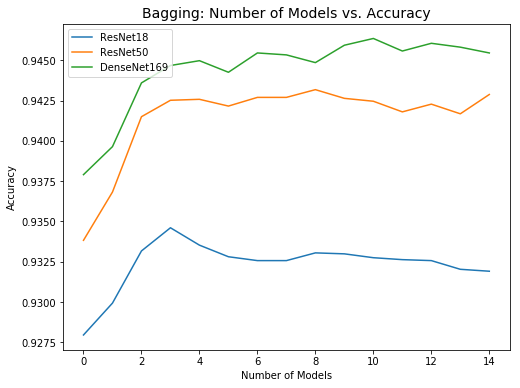

In [15]:
fig, ax = plt.subplots(figsize=(8, 6))

x = list(range(15))
plt.plot(x, int_acc_list_r18)
plt.plot(x, int_acc_list_r50)
plt.plot(x, int_acc_list_dn169)
plt.title('Bagging: Number of Models vs. Accuracy', fontsize=14)
plt.xlabel('Number of Models')
plt.ylabel('Accuracy')
plt.legend(['ResNet18', 'ResNet50', 'DenseNet169'], loc='upper left')
plt.show()

fig.savefig('/media/rene/Data/camelyon_out/figures/bagging_num_models.jpeg', bbox_inches='tight', pad_inches=0)

In [3]:
print(acc_r18, acc_r50, acc_dn169)

NameError: name 'acc_r18' is not defined

* Add in above graph, mention how don't see much improvement from bagging after a few models, and how ResNet18 was really affected by model variance.
* Need a bar graph comparing a bunch of model's perfromances. Show how bagging loses to just averaging models.
* Need a graph comparing the different resnet sizes and their perfromance on average and after bagging. Show somehting about how model size is related to how much bagging helps.

0.01